## POBRANIE I ROZPAKOWANIE ZBIORU DANYCH

In [1]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
!tar -xvf images.tar

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
Images/n02109047-Great_Dane/n02109047_34148.jpg
Images/n02109047-Great_Dane/n02109047_34162.jpg
Images/n02109047-Great_Dane/n02109047_34209.jpg
Images/n02109047-Great_Dane/n02109047_3643.jpg
Images/n02109047-Great_Dane/n02109047_4267.jpg
Images/n02109047-Great_Dane/n02109047_481.jpg
Images/n02109047-Great_Dane/n02109047_5618.jpg
Images/n02109047-Great_Dane/n02109047_5675.jpg
Images/n02109047-Great_Dane/n02109047_5822.jpg
Images/n02109047-Great_Dane/n02109047_5894.jpg
Images/n02109047-Great_Dane/n02109047_5936.jpg
Images/n02109047-Great_Dane/n02109047_6008.jpg
Images/n02109047-Great_Dane/n02109047_6265.jpg
Images/n02109047-Great_Dane/n02109047_6276.jpg
Images/n02109047-Great_Dane/n02109047_6447.jpg
Images/n02109047-Great_Dane/n02109047_6680.jpg
Images/n02109047-Great_Dane/n02109047_7072.jpg
Images/n02109047-Great_Dane/n02109047_7156.jpg
Images/n02109047-Great_Dane/n02109047_7227.jpg
Images/n02109047-Great_Dane/n02109047_74

podłącznie do dysku w celu zapisu modeli i historii

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import os
import shutil
import numpy as np
import tensorflow
import pickle
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.applications.resnet import ResNet152, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Model
from keras.optimizers import Adam
from tensorflow.keras.layers import Dense
from IPython.display import Image, display

In [4]:
datagen = ImageDataGenerator()
dataset = datagen.flow_from_directory('Images')
#utworzenie listy klas - w tym przypadku ras psów
breeds = []

# Funkcja zmieniająca skomplikowane nazwy plików na wyłącznie nazwy ras
def rename(name):
    return ' '.join(' '.join(name.split('-')[1:]).split('_'))

for n in dataset.class_indices:
    breeds.append(rename(n))


Found 20580 images belonging to 120 classes.


In [5]:


# ścieżki do folderów z danymi ze stanford dogs
SOURCE_DIR = "Images"
TRAIN_DIR = "train"
VALIDATE_DIR = "validate"
TEST_DIR = "test"



# Proportional split for train, validate, test sets
TRAIN_RATIO = 0.7
VALIDATE_RATIO = 0.1

def split_dataset(source_dir, train_dir, validate_dir, test_dir, train_ratio, validate_ratio):
    if not os.path.exists(source_dir):
        print(f"Source directory {source_dir} does not exist!")
        return

    np.random.seed(213)# ten sam seed w celu powtarzalności podziału danych

    for class_name in os.listdir(source_dir):
        # Tworzenie katalogów dla klas w zbiorach docelowych
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(validate_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)

        # Lista wszystkich obrazów w klasie
        images = os.listdir(os.path.join(source_dir, class_name))
        np.random.shuffle(images)

        # Obliczanie liczby obrazów w każdym podzbiorze
        n_train = int(len(images) * train_ratio)
        n_validate = int(len(images) * validate_ratio)
        n_test = len(images) - n_train - n_validate

        # Podział obrazów
        for i, img in enumerate(images):
            source_img = os.path.join(source_dir, class_name, img)
            if i < n_train:
                shutil.copy(source_img, os.path.join(train_dir, class_name, img))
            elif i < (n_train + n_validate):
                shutil.copy(source_img, os.path.join(validate_dir, class_name, img))
            else:
                shutil.copy(source_img, os.path.join(test_dir, class_name, img))

split_dataset(SOURCE_DIR, TRAIN_DIR, VALIDATE_DIR, TEST_DIR, TRAIN_RATIO, VALIDATE_RATIO)




In [6]:
BATCH_SIZE = 64

# tworzenie ImageDataGenerators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(TRAIN_DIR, target_size=(256,256), batch_size=BATCH_SIZE, class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(VALIDATE_DIR, target_size=(256,256), batch_size=BATCH_SIZE*2, class_mode='categorical')
test_generator = validation_datagen.flow_from_directory(TEST_DIR, target_size=(256,256), batch_size=BATCH_SIZE*2, class_mode='categorical', shuffle=False)

Found 14355 images belonging to 120 classes.
Found 2009 images belonging to 120 classes.
Found 4216 images belonging to 120 classes.
234698864/234698864 [==============================] - 7s 0us/step


In [ ]:

# ładowanie modelu pretrenowanego z usunięciem ostatniej warstwy która jest dla 1000klas, dtanford dogs ma 120


# base_model = VGG16(weights='imagenet', include_top=False, pooling='avg', input_shape=(256,256, 3))
# base_model = VGG19(weights='imagenet', include_top=False, pooling='avg', input_shape=(256,256, 3))
# base_model = DenseNet121(weights='imagenet', include_top=False, pooling='avg', input_shape=(256,256, 3))
# base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(256,256, 3))
# base_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg', input_shape=(256,256, 3))
# base_model = MobileNetV2(weights='imagenet', include_top=False, pooling='avg', input_shape=(256,256, 3))
base_model = ResNet152(weights='imagenet', include_top=False, pooling='avg', input_shape=(256,256, 3))

# Dodawanie warstwy odpowiadającej za wyjscie
output = Dense(120, activation='softmax')(base_model.output)

# towrzenie instancji modelu
model = Model(inputs=base_model.input, outputs=output)


In [7]:

# kompilacja modelu
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
#liczba epok
EPOCHS = 20

In [8]:
# trening modelu i zapis histori oraz modelu w celu nie utracenia wyników
history = model.fit(train_generator, epochs=EPOCHS, validation_data=validation_generator)
model.save("/content/drive/MyDrive/Colab Notebooks/dane/tensor/model_ResNet152.h5")
with open('/content/drive/MyDrive/Colab Notebooks/dane/tensor/ResNet152_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)


Epoch 1/20
449/449 [==============================] - 253s 499ms/step - loss: 4.6899 - accuracy: 0.0215 - val_loss: 4.7148 - val_accuracy: 0.0239
Epoch 2/20
449/449 [==============================] - 218s 485ms/step - loss: 4.1879 - accuracy: 0.0576 - val_loss: 5.2214 - val_accuracy: 0.0353
Epoch 3/20
449/449 [==============================] - 218s 486ms/step - loss: 3.6997 - accuracy: 0.1129 - val_loss: 4.5549 - val_accuracy: 0.0453
Epoch 4/20
449/449 [==============================] - 218s 486ms/step - loss: 3.2365 - accuracy: 0.1813 - val_loss: 3.7222 - val_accuracy: 0.1344
Epoch 5/20
449/449 [==============================] - 219s 487ms/step - loss: 2.8552 - accuracy: 0.2512 - val_loss: 3.9764 - val_accuracy: 0.1299
Epoch 6/20
449/449 [==============================] - 219s 488ms/step - loss: 2.4642 - accuracy: 0.3338 - val_loss: 3.9417 - val_accuracy: 0.1518
Epoch 7/20
449/449 [==============================] - 219s 487ms/step - loss: 2.0718 - accuracy: 0.4206 - val_loss: 3.3224 -

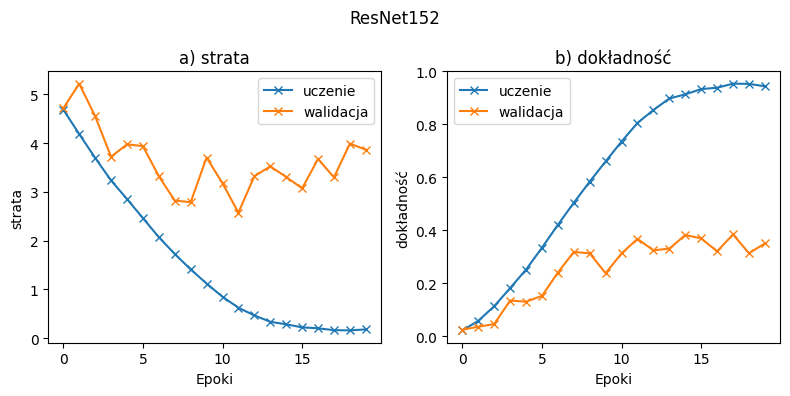

In [9]:

    #jeżeli chcemy wyświetlić wykresy bezpśrednio po uczeniu modelu
# history_data = model.history.history

#jeżeli chcemy pobrać wybrany model
with open('/content/drive/MyDrive/Colab Notebooks/dane/tensor/ResNet152_history.pkl', 'rb') as f:
    history_data = pickle.load(f)

# Wykres dla straty i dokładności
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(8 ,4))

# Wykres dla straty
ax1.plot(history_data['loss'], label='uczenie', marker="x")
ax1.plot(history_data['val_loss'], label='walidacja', marker="x")
ax1.set_title("a) strata")
ax1.set_xlabel("Epoki")
ax1.set_ylabel("strata")
ax1.legend()

# Wykres dla dokładności
ax2.plot(history_data['accuracy'], label='uczenie', marker="x")
ax2.plot(history_data['val_accuracy'], label='walidacja', marker="x")
ax2.set_title("b) dokładność")
ax2.set_xlabel("Epoki")
ax2.set_ylabel("dokładność")
ax2.legend()

# Dodanie głównego tytułu
fig.suptitle("ResNet152")  # Zmień na odpowiednią nazwę modelu

# Ostateczne wyświetlenie wykresu
plt.tight_layout()
plt.show()


Ewaluacja jak model radzi sobie na danych testowych których wcześniej nie widział - wykresy z top5 predykcji

1/1 [==============================] - 3s 3s/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 36ms/step


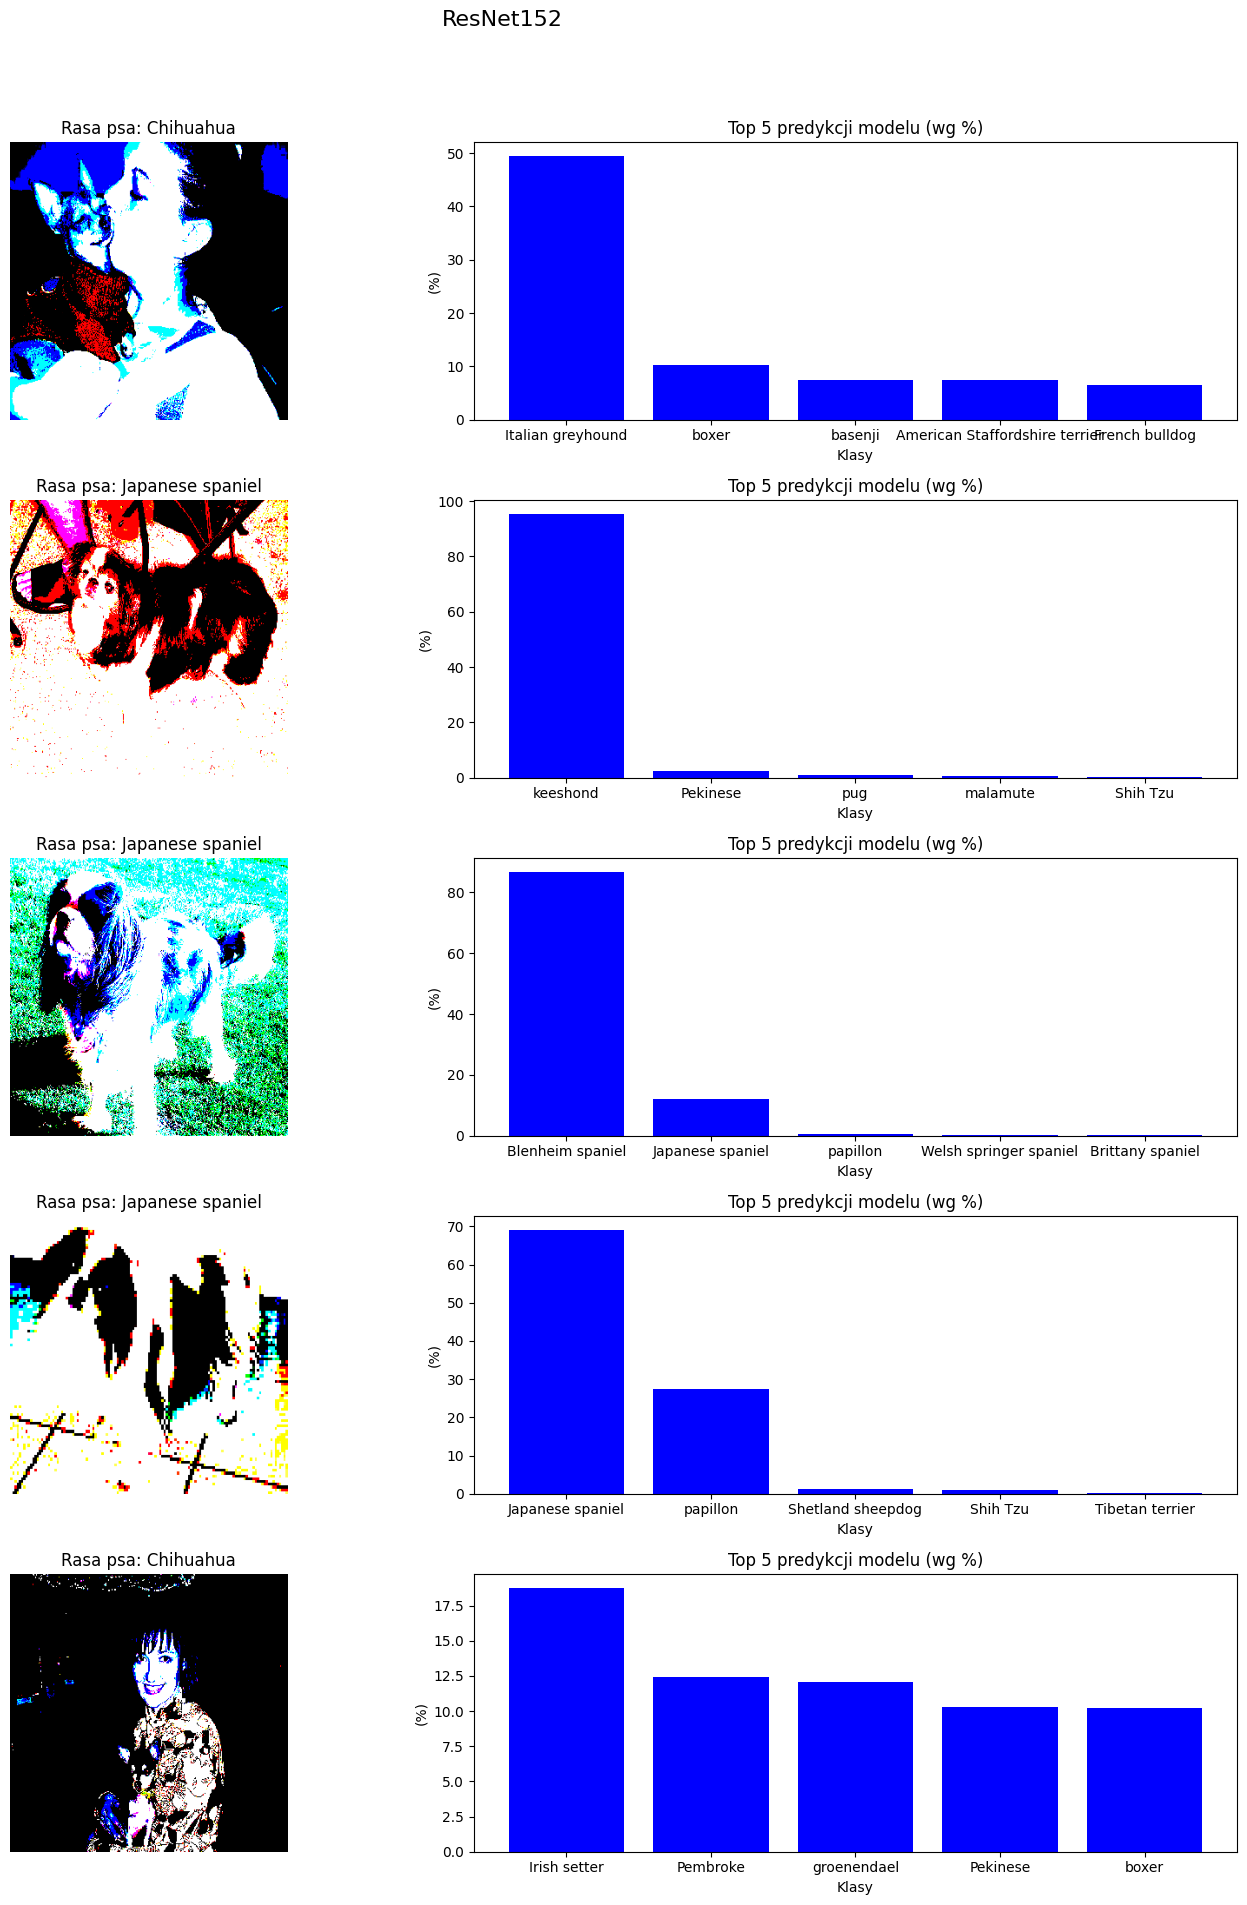

In [10]:

# Zakładając, że jest już wczytany zbiór testowy w test_generator
test_images, test_labels = next(test_generator)

positions = [8, 38, 53,33,15]
fig, axarr = plt.subplots(len(positions), 2, figsize=(15, 20))
plt.suptitle("ResNet152", fontsize=16)  # Tutaj wstawiamy odpowiednią nazwę modelu

for idx, position in enumerate(positions):
    image = test_images[position]
    label = np.argmax(test_labels[position])

    # Wykonaj inferencję
    probabilities = model.predict(np.expand_dims(image, axis=0))[0] * 100
    top5_prob = np.sort(probabilities)[-5:][::-1]
    top5_idx = np.argsort(probabilities)[-5:][::-1]

    class_names = breeds
    top5_classes = [class_names[i] for i in top5_idx]

    # Wyświetl zdjęcie
    axarr[idx, 0].imshow(image)
    axarr[idx, 0].axis('off')  # Wyłącz osie na obrazie
    axarr[idx, 0].set_title(f"Rasa psa: {class_names[label]}")

    # Narysuj wykres słupkowy
    axarr[idx, 1].bar(top5_classes, top5_prob, color='blue')
    axarr[idx, 1].set_xlabel("Klasy")
    axarr[idx, 1].set_ylabel("(%)")
    axarr[idx, 1].set_title("Top 5 predykcji modelu (wg %)")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Ewalucja modelu na danych testowych

In [11]:
loss, accuracy = model.evaluate(test_generator, verbose=0)
print(f'Strata na zestawie testowym: {loss:.4f}')
print(f'Dokładność modelu na Sestawie testowym: {accuracy * 100:.2f}%')

Strata na zestawie testowym: 2.3615
Dokładność modelu na zestawie testowym: 51.45%


Blok odpowiadający za wspólny wykres wszystkich modeli

In [22]:

model1 = load_model('/content/drive/MyDrive/Colab Notebooks/dane/tensor/model_ResNet50.h5')
model2 = load_model('/content/drive/MyDrive/Colab Notebooks/dane/tensor/model_VGG16.h5')
model3 = load_model('/content/drive/MyDrive/Colab Notebooks/dane/tensor/model_VGG19.h5')
model4 = load_model('/content/drive/MyDrive/Colab Notebooks/dane/tensor/model_DenseNet121.h5')
model5 = load_model('/content/drive/MyDrive/Colab Notebooks/dane/tensor/model_InceptionV3.h5')
model6 = load_model('/content/drive/MyDrive/Colab Notebooks/dane/tensor/model_MobileNetV2.h5')
model7 = load_model('/content/drive/MyDrive/Colab Notebooks/dane/tensor/model_ResNet152.h5')

models = ['Resnet50', 'VGG16', 'VGG19', 'DenseNet121', 'InceptionV3', 'MobileNetV2', 'Resnet152']
loss1, accuracy1 = model1.evaluate(test_generator)
loss2, accuracy2 = model2.evaluate(test_generator)
loss3, accuracy3 = model3.evaluate(test_generator)
loss4, accuracy4 = model4.evaluate(test_generator)
loss5, accuracy5 = model5.evaluate(test_generator)
loss6, accuracy6 = model6.evaluate(test_generator)
loss7, accuracy7 = model7.evaluate(test_generator)

accuracies = [accuracy1, accuracy2, accuracy3, accuracy4, accuracy5, accuracy6, accuracy7]
losses = [loss1,loss2,loss3,loss4, loss5, loss6, loss7]
accuracies = [acc * 100 for acc in accuracies]


# Plotting the Accuracy bar graph
plt.figure(figsize=(12, 6))
plt.bar(models, accuracies, color='blue')
plt.xlabel('Nazwa modeli')
plt.ylabel('Dokładność')
plt.title('Dokładność modeli w TensorFlow')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting the Loss bar graph
plt.figure(figsize=(12, 6))
plt.bar(models, losses, color='red')
plt.xlabel('Nazwa modeli')
plt.ylabel('Strata')
plt.title('Strata modeli w TensorFlow')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

KeyboardInterrupt: ignored

Blok odpowiadający za wspólny wykres wszystkich modeli tylko, że z liczbami przy słupkach

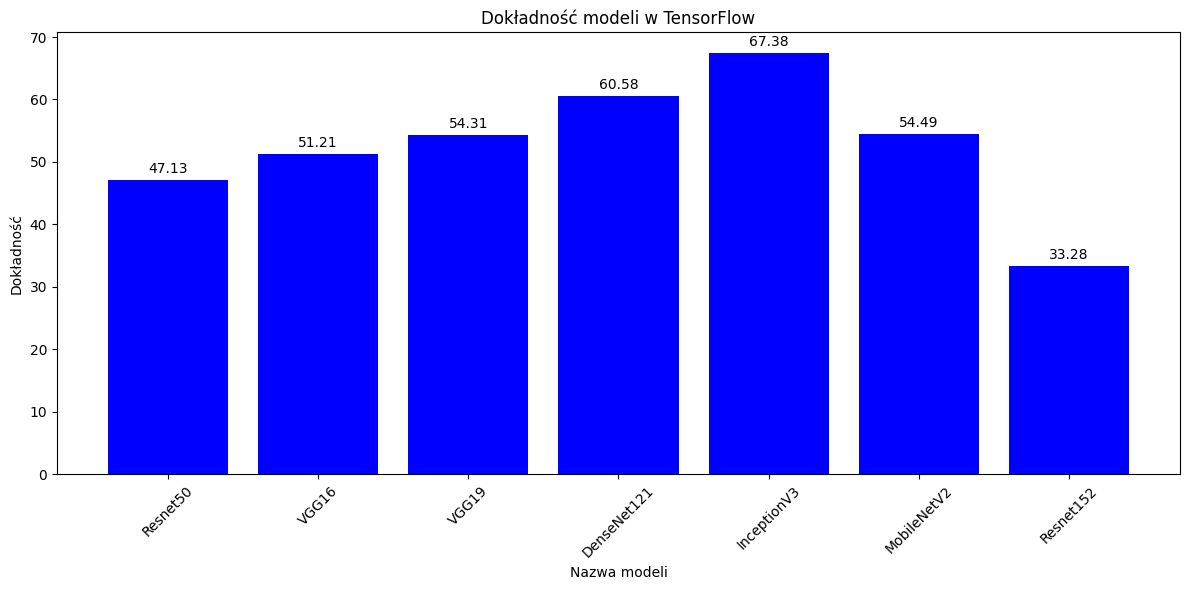

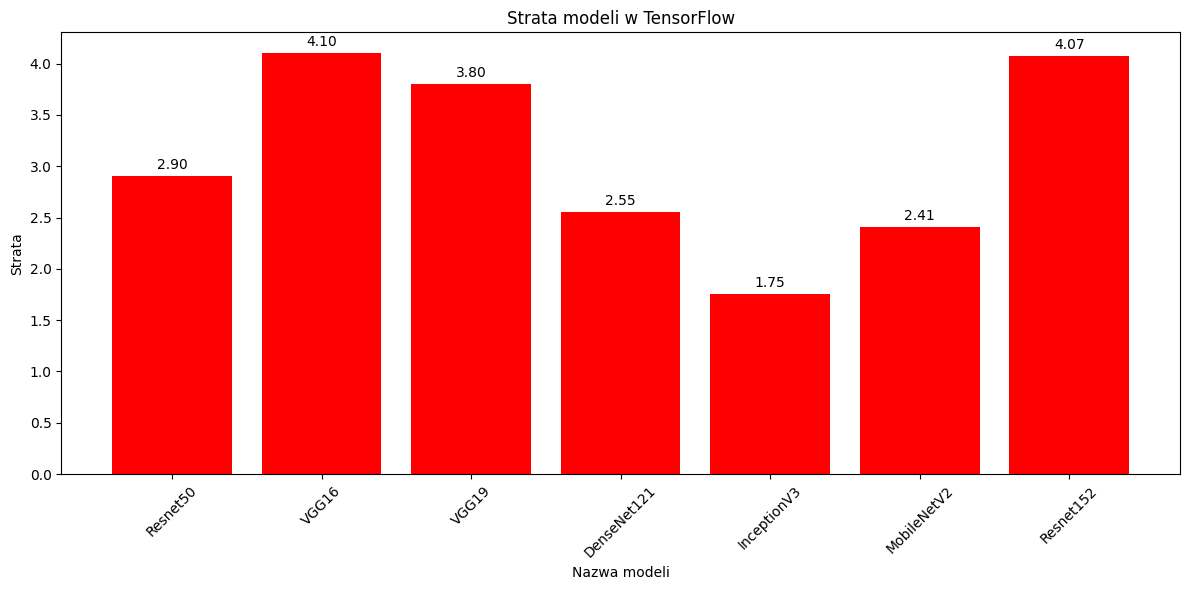

In [28]:

def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),  # 3 points vertical offset
                     textcoords="offset points",
                     ha='center', va='bottom')

# plotowanie accuracy wykresu
plt.figure(figsize=(12, 6))
bars_acc = plt.bar(models, accuracies, color='blue')
plt.xlabel('Nazwa modeli')
plt.ylabel('Dokładność')
plt.title('Dokładność modeli w TensorFlow')
plt.xticks(rotation=45)
annotate_bars(bars_acc)
plt.tight_layout()
plt.show()

# plotowanie loss wykresu
plt.figure(figsize=(12, 6))
bars_loss = plt.bar(models, losses, color='red')
plt.xlabel('Nazwa modeli')
plt.ylabel('Strata')
plt.title('Strata modeli w TensorFlow')
plt.xticks(rotation=45)
annotate_bars(bars_loss)
plt.tight_layout()
plt.show()